## **Set up Environment**

In [4]:
#install aimodelshare library
%%capture
! pip install aimodelshare --upgrade

In [2]:
# Download and unpack data
%%capture
!pip install --upgrade --no-cache-dir gdown
!gdown --id '1-Ku-fu1X9pge26ZMji_yCKQqWDWbajCV' -O "COVID-19_Radiography_Database.zip"
!unzip COVID-19_Radiography_Database.zip 

In [5]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

## **Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor functions are used to preprocess data into the precise data your model requires to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  


In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
#preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (100).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1024).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1031).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

## **Data Exploration & Visualizations**

 ### Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not (You can present visuals of each category in the data if you would like to.).

In [ ]:
# Creating new df with y_train for visualization
import numpy as np

df_plot = y_train.copy()
df_plot['Disease'] = np.where(df_plot['COVID'] == 1, "Covid", "Normal")
df_plot['Disease'] = np.where(df_plot['PNEUMONIA'] == 1, "Pneumonia", df_plot['Disease'])
df_plot.head()

,COVID,NORMAL,PNEUMONIA,Disease
3256,0,0,1,Pneumonia
1265,0,1,0,Normal
1188,1,0,0,Covid
118,1,0,0,Covid
3215,0,0,1,Pneumonia


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Diseases in Dataset')

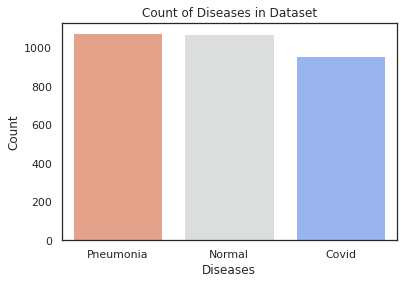

In [ ]:
import seaborn as sns
sns.set()

sns.set_style("white")
sns.countplot(df_plot['Disease'], color='gray',
              palette= "coolwarm_r") # YlOrRd_r cividis
plt.ylabel("Count")
plt.xlabel("Diseases")
plt.title("Count of Diseases in Dataset")

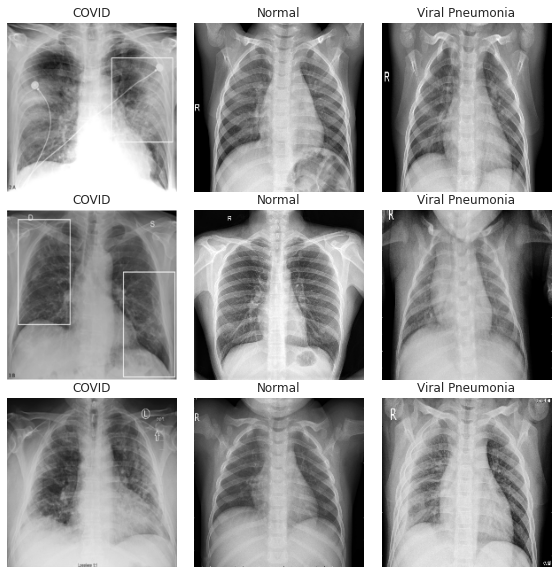

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1100).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1103).png')
im7 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1090).png')

im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1010).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1050).png')
im8 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1090).png')

im5 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1000).png')
im6 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1050).png')
im9 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1200).png')


fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im3, im5, im2, im4 , im6, im7, im8, im9]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    if((im == im1 )| (im ==im2) | (im == im7 )).all():
    #ax[2, 3].set_title('COVID')
      ax.axes.set_title('COVID')
    elif ((im == im3 )| (im ==im4) | (im == im8 )).all():
      ax.axes.set_title('Normal')
    elif ((im == im5 )| (im ==im6) | (im == im9 )).all():
      ax.axes.set_title('Viral Pneumonia')
    #ax[2].set_title('COVID')
    #ax[3].set_title('COVID')
    #ax.set_title('Subject {0} in-Trial Gaze')

    ax.axis('off')
plt.show()


I comared three random x-rays from each category. Just after a quick glance, the biggest difference that stands out is that x-rays for both covid and viral pneumonia look a lot milkier than the x-rays for the Normal category. Lung x-rays for the normal category seem very clear and each rib stands out pretty distinctly. 


It is hard to differentiate between the Covid and Pneumonia xrays. In the case of Covid, it is difficult to count each rib due to some substance in the lungs. In viral pneumonia, it is slightly easier to point out the ribs but the dark spaces in between them ribs also seem to have some sort of substance filled in them. After a quick google search, the milkiness comes from interstitial infiltrates and bilateral infiltrates in the lungs. These parts look a little more localized in the case of Covid. For Viral pneumonia, the inflitrates seem spread out throughout the lungs. 

 ### Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful. Who could benefit from a model like this? Explain.


The dataset contains chest x-rays for three difference categories of people: people who were covid positive, those who had viral pneumonia, and those who were normal (absence of the two diseases). The dataset we are using in this notebook has a total of 3,886 chest x-ray images: 1200 from covid patients, 1345 from viral pneumonia patients, and 1341 from people who did not have either.

The paper from which this dataset comes was published in March 2020 (revised June 2020), which was very early on in the pandemic. Back then, the government had not yet invested in expanding testing capabilities and testing covid through RT-PCR was proving to be quite cumbersome and expensive. The virus was spreading rapidly and there was a need for a technique to quickly classify people as covid positive or negative. From what I read in the link attached to the prompt, the need this technique was fulfilling was for a an easily accessible tool that could be an excellent alternative in the COVID-19 diagnosis. 

A predictive model like this would have been a viable and useful tool because it could easily make up for/supplement the limited testing capacity at all health instituitions in the early stages of the pandemic. All medical institutions, government health bodies, and even the general public would have benefited from this predictive model. 

## **Save Preprocessor**
### Saves preprocessor function to "preprocessor.zip" file

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

## **Submit Models**

In [9]:
#Instantiate Competition 


mycompetition= ai.Competition("https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m")


In [7]:
#Authorized users can submit new models after setting credentials using modelshare.org username/password

apiurl="https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m" # example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m

import aimodelshare
aimodelshare.aws.set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


#### Model 1 (Model no. 79)

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

98/98 [==============================] - 515s 5s/step - loss: 0.4568 - accuracy: 0.8179 - val_loss: 0.2069 - val_accuracy: 0.9280


In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

In [ ]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 79

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1539


Get Leaderboard

In [ ]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

Compare Models

In [ ]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
data=mycompetition.compare_models([1,2], verbose=1)
mycompetition.stylize_compare(data)

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_2_Layer,Model_2_Shape,Model_2_Params
0,Conv2D,"[None, 192, 192, 32]",896,Conv2D,"[None, 192, 192, 32]",896.000000
1,Conv2D,"[None, 192, 192, 32]",1056,Conv2D,"[None, 192, 192, 32]",1056.000000
2,MaxPooling2D,"[None, 96, 96, 32]",0,MaxPooling2D,"[None, 96, 96, 32]",0.000000
3,Conv2D,"[None, 96, 96, 64]",18496,Conv2D,"[None, 96, 96, 64]",18496.000000
4,Conv2D,"[None, 96, 96, 64]",4160,Conv2D,"[None, 96, 96, 64]",4160.000000
5,MaxPooling2D,"[None, 48, 48, 64]",0,MaxPooling2D,"[None, 48, 48, 64]",0.000000
6,Conv2D,"[None, 48, 48, 128]",73856,Conv2D,"[None, 48, 48, 128]",73856.000000
7,Conv2D,"[None, 48, 48, 128]",16512,Conv2D,"[None, 48, 48, 128]",16512.000000
8,MaxPooling2D,"[None, 24, 24, 128]",0,MaxPooling2D,"[None, 24, 24, 128]",0.000000
9,Conv2D,"[None, 24, 24, 512]",590336,Conv2D,"[None, 24, 24, 512]",590336.000000


##### Check structure of y test data 
(This helps users understand how to submit predicted values to leaderboard)

In [ ]:
mycompetition.inspect_y_test()

{'class_balance': {'COVID': 240, 'NORMAL': 269, 'PNEUMONIA': 269},
 'class_labels': ['COVID', 'PNEUMONIA', 'NORMAL'],
 'label_dtypes': {"<class 'str'>": 778},
 'y_length': 778,
 'ytest_example': ['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA']}

#### Model 2 (Model no. 116)

Added an extra dense layer after the flatten layer.

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

98/98 [==============================] - 530s 5s/step - loss: 0.6034 - accuracy: 0.7474 - val_loss: 0.2397 - val_accuracy: 0.9165


In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[2 1 0 1 2 0 1 0 1 2 2 1 0 2 0 2 0 1 1 2 2 0 1 0 1 2 2 1 1 0 1 0 1 1 2 0 1
 2 0 0 2 0 1 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 2 1 0 2 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 2 2 1 0 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 2 1 1 2 1 0 0 0
 2 1 2 1 1 1 2 2 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 0
 2 0 1 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 2 1 1 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 2 2 1 0 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 2 0 2 1 0 2 2 2 0 2
 0 1 1 1 2 2 1 2 1 1 1 0 2 0 1 2 1 1 2 2 1 1 0 1 2 0 0 0 1 0 2 2 1 0 2 2 2
 2 0 1 0 0 1 2 2 1 0 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 1 2 1 0 0 2 2 1 2 0 1 1 2 0 0 2 0 1 1 1 2 2 0 0 2 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 2 1 2 1 2 0 2 2 0 0 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 1 1 0 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 0
 1 1 1 1 1 0 1 0 2 1 0 2 

In [ ]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 116

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1539


#### Model 3 (Model no. 126)

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2DTranspose(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax') 
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

98/98 [==============================] - 2649s 27s/step - loss: 0.5840 - accuracy: 0.8205 - val_loss: 0.2118 - val_accuracy: 0.9306


In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 1 2 0 1 1 2 1 2 1 0 2 2 2 1 1 2 1 0 1 1 1 0 2
 2 0 2 2 0 1 0 1 1 0 0 1 1 2 0 2 1 2 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 2 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 0 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 0 1 1 1 2 1 2 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 0
 2 0 2 1 1 2 1 1 2 1 1 2 1 2 2 0 1 0 1 0 2 0 0 1 1 1 1 0 0 1 1 1 1 0 2 2 0
 2 2 2 2 2 1 2 1 0 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 0 0 2 2 1 1 2 2 1 1 0 2 2 0 2 0 1 0 2 2 1 0 2 2 2
 2 0 1 0 0 1 2 2 1 2 0 1 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 1 1 1 0 1 0
 1 0 1 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 1 0 0 2 0 2 1 1 2 2 0 0 1 2 0 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 2 1 0 1 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 2 1 2 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 1
 1 1 1 1 1 0 2 0 2 1 0 2 

In [ ]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 126

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1539


### Model 4 (Model No. 124)

In [ ]:
# Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
with tf.device('/device:GPU:0'):


  # Convolutional Neural Network
 # from keras.utils import plot_model
  from keras.models import Model
  from keras.layers import Input
  from keras.layers import Dense
  from keras.layers import Flatten
  from keras.layers.convolutional import Conv2D
  from keras.layers.pooling import MaxPooling2D
  visible = Input(shape=(192,192, 3))
  conv1 = Conv2D(32, kernel_size=4, activation='relu', padding="same")(visible)
  conv2 = Conv2D(16, kernel_size=4, activation='relu')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
  #conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool1)
  #conv3 = Conv2D(16, kernel_size=4, activation='relu')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(pool1)
  #pool3 = MaxPooling2D(pool_size=(2, 2))(pool2)
  #conv4 = Conv2D(16, kernel_size=4, activation='relu')(pool3)
  #conv5 = Conv2D(16, kernel_size=4, activation='relu')(conv4)
  #pool4 = MaxPooling2D(pool_size=(2, 2))(conv5)
  flat = Flatten()(pool2)
  hidden1 = Dense(10, activation='relu')(flat)
  output = Dense(3, activation='softmax')(hidden1)
  model = Model(inputs=visible, outputs=output)


  model.compile(
    loss= "categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate =0.001),
    metrics=["accuracy"],)
  
  model.fit(X_train, y_train, 
            epochs = 1, verbose=1,
            validation_data=(X_test,y_test))



98/98 [==============================] - 510s 5s/step - loss: 0.5587 - accuracy: 0.7255 - val_loss: 0.2370 - val_accuracy: 0.9203


In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[2 1 0 1 2 0 1 0 1 2 2 1 0 2 0 2 0 1 2 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 1 0 2
 1 0 2 2 0 1 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 2 0 1 2 1 0 2 1 1 0 2 1 1 2 2 0 2 0 1 0 0 1 0 0 2 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 0 1 1 0 0 0 2 0 1 1 2 1 0 0 0 2 0 1 0 1 1 1 2 1 0 0 0
 1 1 0 1 1 1 2 0 0 0 2 1 2 2 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 0 2 2 1 1 0
 2 0 1 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 0 2 2 0
 2 2 2 0 2 1 2 1 0 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 2 2 1 1 2 2 1 1 0 0 2 0 0 0 1 0 2 2 1 0 2 2 2
 2 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 0 0 2 1 2 2 1 0 0 2 2 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 1 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 2 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 0 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 0 1 2 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 0
 1 1 1 2 1 0 1 0 2 1 0 2 

In [ ]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

##### Conclusion: **____________________**

### Model 5 - Transfer Learning

I am using the VGGNet architecture for transfer learning, sepcifically the pretrained VGG16. 


In [26]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K
from keras.layers.convolutional import Conv2DTranspose

base_model = VGG16(input_shape=(192,192,3), 
                   include_top=False, 
                   weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [28]:

with tf.device('/device:GPU:0'): 
  
  # Getting output tensor of the last VGG layer that we want to include
  # base_model.layers[-1].output sets input for next model layer

  # example of tending the vgg16 model
  from tensorflow.keras.applications.vgg16 import VGG16
  from tensorflow.keras.models import Model
  from tensorflow.keras.layers import Dense
  from tensorflow.keras.layers import Flatten

  # Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
  flat1 = Flatten()(base_model.layers[-1].output)
  class1 = Dense(1024, activation='relu')(flat1)
  output = Dense(3, activation='softmax')(class1)
  # define new model
  model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model
    
  # summarize

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=50,
          epochs = 3, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/3
63/63 [==============================] - ETA: 0s - loss: 1.2084 - acc: 0.6515 
Epoch 00001: val_acc improved from -inf to 0.48972, saving model to best_model.h5
63/63 [==============================] - 1271s 20s/step - loss: 1.2084 - acc: 0.6515 - val_loss: 0.9221 - val_acc: 0.4897 - lr: 0.0100
Epoch 2/3
63/63 [==============================] - ETA: 0s - loss: 0.4374 - acc: 0.8266 
Epoch 00002: val_acc improved from 0.48972 to 0.92159, saving model to best_model.h5
63/63 [==============================] - 1275s 20s/step - loss: 0.4374 - acc: 0.8266 - val_loss: 0.2916 - val_acc: 0.9216 - lr: 0.0100
Epoch 3/3
63/63 [==============================] - ETA: 0s - loss: 0.3405 - acc: 0.8723 
Epoch 00003: val_acc did not improve from 0.92159
63/63 [==============================] - 1271s 20s/step - loss: 0.3405 - acc: 0.8723 - val_loss: 0.3345 - val_acc: 0.8560 - lr: 0.0100


In [29]:
with tf.device('/device:GPU:0'): 
  # Save Model to .onnx file
  from aimodelshare.aimsonnx import model_to_onnx

  # Save tf.keras model to ONNX file
  onnx_model = model_to_onnx(model, framework='keras',
                            transfer_learning=False,
                            deep_learning=True)

  # Save model to local .onnx file
  with open("model.onnx", "wb") as f:
      f.write(onnx_model.SerializeToString()) 

In [ ]:
with tf.device('/device:GPU:0'): 
  # using predict_classes() for multi-class data to return predicted class index.

  def predict_classes(x): # adjusted from keras github code
    proba=x
    if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
    else:
        return (proba > 0.5).astype("int32")

  print(predict_classes(model.predict(X_test)))

  prediction_index=predict_classes(model.predict(X_test))

  #Now lets run some code to get keras to return the label rather than the index...

  # get labels from one hot encoded y_train data
  labels=pd.get_dummies(y_train).columns

  # Iterate through all predicted indices using map method
  prediction_labels=list(map(lambda x: labels[x], prediction_index))

  # Submit Model 1 to Competition Leaderboard
  mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

[0 1 0 1 2 0 1 0 1 2 1 1 0 2 0 1 0 1 1 2 2 2 2 0 2 0 2 2 1 2 2 0 1 1 1 0 1
 1 0 2 0 0 2 0 1 1 0 0 2 1 0 0 2 1 1 2 1 0 1 2 2 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 0 0 2 0 1 1 1 0 2 0 2 0 1 2 0 1 0 0 1 0 1 0 2 0 0 0
 0 0 0 2 2 0 1 0 2 1 2 1 1 0 2 0 2 0 1 1 2 1 0 0 0 0 0 1 0 0 1 1 2 1 0 0 0
 1 1 0 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 0 0 0 1 2
 1 0 2 1 1 2 1 0 2 1 1 2 1 0 2 0 1 0 1 0 2 0 2 1 1 0 2 0 0 1 1 1 1 2 2 2 0
 0 2 0 0 2 1 0 1 1 2 0 1 0 1 1 1 0 2 1 1 0 0 1 0 2 0 1 1 0 0 1 0 2 2 0 0 0
 0 1 0 1 2 2 2 2 1 1 1 0 2 0 2 0 2 2 2 2 1 1 0 1 2 0 0 0 1 0 1 2 1 0 0 1 2
 2 0 1 0 0 1 0 2 1 2 0 0 1 2 0 1 0 2 1 0 0 2 0 2 1 0 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 0 1 0 2 0 0 0 2 0 2 0 0 1 2 0 0 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 0 2 2 1 1 0 2 1 1 2 0 1 1 0 0 0 2 0 2 1 1 2 2 0 0 1 0 2 0 1 0 0 2
 0 2 1 0 1 1 0 0 2 2 0 1 0 0 0 0 1 2 0 1 0 1 2 0 0 1 1 2 1 2 0 2 2 0 2 2 1
 2 0 0 0 0 2 1 1 2 0 0 2 1 0 1 2 1 1 2 0 1 2 0 2 0 1 0 2 0 0 0 0 0 0 1 0 0
 1 1 1 1 1 0 1 0 0 1 0 2 

From the accuracy score, the VGGNet model seemed to have performed somewhere in the middle, in realtion to other models on the leaderboard. Although, I couldn't actually compare it to the other models because my session crashed every time I tried to submit the model as an onnx object. That might have something to do with the size of the model. 

During training, it performed quite poorly in the first epoch with a validation accuracy of just 0.4897. However, the model validation accruacy improved tremendously in the second epoch when it gave back a score of 0.9216. The score didn't improve in the third and final epoch. 




In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

### Discuss which models performed better and point out relevant hyper-parameter values for successful models.

Out of all the models I ran, my third model (model 126) had the higest score. The biggest difference in this model, compared to Model 2 was that I included a conv2dtranspose layer. This model scored an accuracy score of 93.06% and f1 score of 93.06%.

This model had two convolutional layers with filter size 32, followed by two 2X2 max pooling layers. This was followed by the conv2dtranspose layer with a filter size of 512, and then two convolutional layers with filter size of 512 as well. After flattening the layers, there was one fully connected layer with 16 nodes. For the optimizer, I used adam. 

Model 3 had a lot less layers than model 1 and Model 2, and slightly more layers than model 4. Additionally, the conv2dtranspose layer was also a huge difference from the other models. 

### Leaderboard

In [10]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,lambda_layers,conv2dtranspose_layers,dense_layers,inputlayer_layers,averagepooling2d_layers,concatenate_layers,flatten_layers,conv2d_layers,layernormalization_layers,dropout_layers,batchnormalization_layers,zeropadding2d_layers,globalmaxpooling2d_layers,maxpooling2d_layers,globalaveragepooling2d_layers,add_layers,elu_act,sigmoid_act,relu_act,softmax_act,loss,optimizer,model_config,memory_size,username,version
0,99.10%,99.12%,99.10%,99.13%,keras,True,True,Functional,309,7051899,nan,nan,2,1.000000,3.000000,58.000000,nan,nan,nan,nan,121.000000,2.000000,nan,1.000000,1.000000,nan,nan,1.000000,121.000000,1.000000,str,Adam,"{'name': 'model_11', 'layers':...",37532832,melissa_feeney,94
1,98.97%,98.99%,99.01%,98.98%,keras,True,True,Functional,308,7040579,nan,nan,1,1.000000,3.000000,58.000000,nan,120.000000,nan,nan,121.000000,2.000000,nan,1.000000,1.000000,nan,nan,1.000000,120.000000,nan,str,Adam,"{'name': 'model_4', 'layers': ...",37202512,melissa_feeney,70
2,98.33%,98.36%,98.36%,98.36%,keras,True,True,Functional,308,7040579,nan,nan,1,1.000000,3.000000,58.000000,nan,nan,nan,nan,121.000000,2.000000,nan,1.000000,1.000000,nan,nan,1.000000,120.000000,nan,str,Adam,"{'name': 'model_2', 'layers': ...",37205400,melissa_feeney,90
3,98.33%,98.36%,98.34%,98.37%,keras,True,True,Functional,24,20079683,nan,nan,1,1.000000,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,5.000000,nan,nan,nan,nan,16.000000,1.000000,str,Adam,"{'name': 'model', 'layers': [{...",2610448,pengyunli,101
4,98.33%,98.36%,98.34%,98.37%,keras,True,True,Functional,24,20079683,nan,nan,1,1.000000,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,5.000000,nan,nan,nan,nan,16.000000,1.000000,str,Adam,"{'name': 'model', 'layers': [{...",2610448,bestcookna,102
5,98.20%,98.26%,98.28%,98.25%,keras,True,True,Functional,22,33593155,nan,nan,2,1.000000,nan,nan,1.000000,13.000000,nan,nan,nan,nan,nan,5.000000,nan,nan,nan,nan,14.000000,1.000000,str,Adam,"{'name': 'model', 'layers': [{...",7965912,qy2245,88
6,98.20%,98.23%,98.24%,98.24%,keras,True,True,Functional,24,20079683,nan,nan,1,1.000000,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,5.000000,nan,nan,nan,nan,16.000000,1.000000,str,Adamax,"{'name': 'model', 'layers': [{...",5036400,bestcookna,103
7,98.07%,98.13%,98.15%,98.14%,keras,False,True,Functional,7,37955075,nan,nan,3,1.000000,nan,nan,1.000000,nan,1.000000,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,2.000000,1.000000,str,SGD,"{'name': 'model', 'layers': [{...",32070056,jc5492,40
8,98.07%,98.12%,98.18%,98.10%,keras,True,True,Functional,308,7040579,nan,nan,1,1.000000,3.000000,58.000000,nan,nan,nan,nan,121.000000,2.000000,nan,1.000000,1.000000,nan,nan,1.000000,121.000000,nan,str,Adam,"{'name': 'model_2', 'layers': ...",41132976,melissa_feeney,22
9,98.07%,98.12%,98.18%,98.10%,keras,False,True,Functional,308,7040579,nan,nan,1,1.000000,3.000000,58.000000,nan,nan,nan,nan,121.000000,2.000000,nan,1.000000,1.000000,nan,nan,1.000000,121.000000,nan,str,Adam,"{'name': 'model_2', 'layers': ...",37220640,melissa_feeney,21


### Best Model 

Due to the memory_szie of the models, I could not import the top 3 models. Model 101 was the 4th best model. This model had a lot more layers than my best performing model (model 3). My best model only had four total convolutional layers and one conv2dtranspose layer along with 2 2 max pooling layers. The best performing model has 21 layers, of which 5 are max pooling layers and the rest are convolutional layers. 

The best performing model used a ModelCheckpoint and ReduceLROnPlateau as additional ways to ensure the validation accuracy keeps improving and that the model doesn't overfit. My best model did not do that.

Fitting and running the best model on the training data and evaluating on the test data (Model no. 128 on the leaderboard): 

In [19]:
best_model = mycompetition.instantiate_model(101) 
best_model.summary()


Instantiate the model from metadata..
Your model is successfully instantiated.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0         
                                                

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs


  best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  best_model.fit(X_train, y_train, batch_size=20, epochs = 2, verbose=1, validation_data=(X_test,y_test),callbacks=[mc,red_lr])


In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(best_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("best_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(best_model.predict(X_test)))

prediction_index=predict_classes(best_model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[2 1 1 1 2 2 1 1 1 2 1 1 2 2 1 2 1 1 1 2 2 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1
 2 2 2 2 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 2 1 2 1 1 2 2 2
 1 2 1 1 2 2 1 1 2 1 1 2 1 2 1 2 1 2 1 2 1 2 2 1 2 2 1 1 2 1 2 1 1 2 1 1 1
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 2 1 1 2 1 1 2 1
 1 1 2 1 1 1 2 1 2 1 2 1 1 2 1 2 2 2 1 1 1 2 1 1 1 2 1 1 1 2 1 2 2 2 1 1 2
 2 2 1 1 1 2 1 1 2 1 1 2 1 2 2 2 1 1 1 1 2 2 2 1 1 1 2 1 1 1 1 1 1 2 2 2 2
 2 2 2 1 2 1 2 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 2 1 2 1 1 1 1 1 2 1 1 2
 1 1 1 1 2 2 1 2 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 2 2 2 1 1 1 2 2 1 1 2 1 2
 2 1 1 1 1 1 2 2 1 2 1 1 1 2 1 1 2 2 1 1 2 2 2 2 1 2 1 1 2 1 2 2 1 1 1 1 2
 1 1 1 2 1 1 2 2 1 1 2 1 2 1 2 1 2 2 2 2 2 1 1 2 1 2 2 2 1 1 2 1 2 2 2 1 1
 1 1 1 2 1 1 2 1 1 2 2 1 1 2 1 1 1 2 2 1 2 2 1 1 1 2 1 1 1 1 2 2 2 1 1 1 2
 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 1 2 1 2 2 1 2 2 2
 1 2 2 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 1 2 2 1 1 1
 1 1 1 2 1 1 2 1 1 1 2 2 

In [ ]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "best_model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 128

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1539


Quite surprisingly, the model performed very poorly on the test data. This could be due to different arguments during the compilation and fitting of the model. 

### Citation


Tan, M., & Le, Q. V. (2020, September 11). EfficientNet: Rethinking model scaling for Convolutional Neural Networks. arXiv.org. Retrieved March 31, 2022, from https://arxiv.org/abs/1905.11946 